In [2]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_probability as tfp


#### Helper functions ####

class DenseNormalGamma(tf.keras.layers.Layer):
    """Implements dense layer for Deep Evidential Regression
    
    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """
    
    def __init__(self, units):
        super(DenseNormalGamma, self).__init__()
        self.units = int(units)
        self.dense = tf.keras.layers.Dense(4 * self.units, activation='linear')

    def evidence(self, x):
        return tf.nn.softplus(x)
        # return tf.nn.relu(x)


    def call(self, x):
        output = self.dense(x)
        mu, logv, logalpha, logbeta = tf.split(output, 4, axis=-1)
        v = self.evidence(logv)
        alpha = self.evidence(logalpha) + 1
        beta = self.evidence(logbeta)
        return tf.concat([mu, v, alpha, beta], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4 * self.units)

    def get_config(self):
        base_config = super(DenseNormalGamma, self).get_config()
        base_config['units'] = self.units
        return base_config


def EvidentialRegression(y_true, evidential_output, coeff=0):
    """Implements loss for Deep Evidential Regression

    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """

    gamma, v, alpha, beta = tf.split(evidential_output, 4, axis=-1)
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta)
    return loss_nll + coeff * loss_reg
    # return loss_nll + (loss_reg - coeff)

def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    #v += 1e-12
    twoBlambda = 2*beta*(1+v) #+ 1e-12
    nll = 0.5*tf.math.log(np.pi/v)  \
        - alpha*tf.math.log(twoBlambda)  \
        + (alpha+0.5) * tf.math.log(v*(y-gamma)**2 + twoBlambda)  \
        + tf.math.lgamma(alpha)  \
        - tf.math.lgamma(alpha+0.5)

    return tf.reduce_mean(nll) if reduce else nll


def NLL(y_true, y_pred, reduce=True):
    
    A = 0.5 * tf.math.log(2 * np.pi * y_pred[:, 1] + 1e-12) 
    B = ((y_true[:, 0] - y_pred[:, 0]) ** 2) / (2 * y_pred[:, 1] ** 2 + 1e-12)
    nll = A + B
    
    return tf.reduce_mean(nll) if reduce else nll

# def NIG_Reg(y, gamma, v, alpha, beta, reduce=True):
#     error = tf.abs(y-gamma)
#     evi = 2*v+(alpha)
#     reg = error*evi

#     return tf.reduce_mean(reg) if reduce else reg


def KL_NIG(mu1, v1, a1, b1, mu2, v2, a2, b2):
    KL = 0.5*(a1-1)/b1 * (v2*tf.square(mu2-mu1))  \
        + 0.5*v2/v1  \
        - 0.5*tf.math.log(tf.abs(v2)/tf.abs(v1))  \
        - 0.5 + a2*tf.math.log(b1/b2)  \
        - (tf.math.lgamma(a1) - tf.math.lgamma(a2))  \
        + (a1 - a2)*tf.math.digamma(a1)  \
        - (b1 - b2)*a1/b1
    return KL

def NIG_Reg(y, gamma, v, alpha, beta, omega=1.01, reduce=True, kl=True):
    # error = tf.stop_gradient(tf.abs(y-gamma))
    error = tf.abs(y-gamma)
    # error = tf.abs( ((y - 0.01252416) / 25.05224608) - ((gamma - 0.01252416) / 25.05224608) )
    # (array([0.01252416]), array([25.05224608]))


    if kl:
        kl = KL_NIG(gamma, v, alpha, beta, gamma, omega, 1+omega, beta)
        reg = error*kl
    else:
        evi = 2*v+(alpha)
        reg = error*evi
        
    return tf.reduce_mean(reg) if reduce else reg


def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    epi = np.sqrt(beta / (v * (alpha - 1)))
    epi = np.minimum(epi, 1e3)[:, 0]  # for visualization
    ale = np.sqrt(beta / (alpha - 1))[:, 0]
    
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.arange(1, n_stds):
        plt.fill_between(
            x_test, (mu - k * epi), (mu + k * epi),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    # plt.gca().set_ylim(-4, 4)

    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()
    

def plot_predictions_scaled(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    epi = np.sqrt(beta / (v * (alpha - 1)))
    epi = np.minimum(epi, 1e3)[:, 0]  # for visualization
    ale = np.sqrt(beta / (alpha - 1))[:, 0]
    
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=0.1, c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-1.73187761, -1.73187761], [-5.98085315, 5.98085315], 'k--', alpha=0.4, zorder=0)
    plt.plot([+1.73187761, +1.73187761], [-5.98085315, 5.98085315], 'k--', alpha=0.4, zorder=0)
    for k in np.arange(1, n_stds):
        plt.fill_between(
            x_test, (mu - k * epi), (mu + k * epi),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-5.98085315, 5.98085315)
    # plt.gca().set_ylim(-4, 4)

    plt.gca().set_xlim(-3.03078582, 3.03078582)
    plt.legend(loc="upper left")
    plt.show()


# if __name__ == "__main__":
#     main()


# import evidential_deep_learning as edl


# def my_data(x_min, x_max, n, train=True):
#     x = np.linspace(x_min, x_max, n)
#     x = np.expand_dims(x, -1).astype(np.float32)

#     sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
#     y = x**3 + np.random.normal(0, sigma).astype(np.float32)
#     noise1 = np.random.normal(0, 10, len(x))
#     scale1 = np.linspace(0, 1, int(len(x) / 2))
#     scale2 = np.linspace(1, 0, int(len(x) / 2))
#     noise = noise1 * np.concatenate([scale1, scale2])
#     y = y * noise
#     # y[400:600] = y[400:600] + noise2.reshape(-1, 1)

#     return x, y

def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    if train:
        sigma = 3 * np.ones_like(x) 
        y = x**3 + np.random.normal(0, sigma).astype(np.float32)
        noise = np.random.normal(0, 10, len(x))
        # scale1 = np.linspace(0, 1, int(len(x) / 2))
        # scale2 = np.linspace(1, 0, int(len(x) / 2))
        # scale = np.concatenate([scale1, scale2])
        # noise = noise1 * scale 
        y = (y.squeeze() + noise).reshape(-1, 1)
    
    else:
        sigma = np.zeros_like(x)
        y = (x**3 + np.random.normal(0, sigma).astype(np.float32))
    return x, y
    # Done!!
    
    
#### Helper functions ####
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return x, y


def loss_uq_normal(y_true, y_pred):
    """
    This is the log-probability loss to calculate uncertainty
    with a normal distribution.
    This form predicts the uncertainty mean and standard deviation
    for a normal distribution.
    From Barnes, Barnes, & Gordillo (2021).
    """

    y_pred64 = tf.cast(y_pred, tf.float64)
    y_true64 = tf.cast(y_true, tf.float64)

    # network prediction of the value
    mu = y_pred64[..., 0]

    # network prediction of uncertainty
    std = tf.math.exp(y_pred64[..., 1])

    # normal distribution defined by N(mu,sigma)
    norm_dist = tfp.distributions.Normal(mu, std)

    # compute the log as -log(p)
    loss = -norm_dist.log_prob(y_true64)

    return tf.reduce_mean(loss)


def normal_unscale_tf(mu, sigma, YMeans, YStds,
                      nSamples=100,
                      uqLow=2.5, uqHigh=97.5):

    cond_dist = tfp.distributions.Normal(mu, sigma)
    sample_scaled = cond_dist.sample(nSamples).numpy()
    sample = YStds * sample_scaled + YMeans

    pmean = np.mean(sample, axis=0)
    pmedian = np.median(sample, axis=0)
    pstd = np.std(sample, axis=0)
    pmin = np.percentile(sample, uqLow, axis=0)
    pmax = np.percentile(sample, uqHigh, axis=0)

    return pmean, pmedian, pstd, pmin, pmax

In [5]:
# # Create some training and testing data
# x_train, y_train = my_data(-4, 4, 1000)
# x_test, y_test = my_data(-7, 7, 1000, train=False)
# input_scaler = StandardScaler()
# output_scaler = StandardScaler()
# x_train_scaled = input_scaler.fit_transform(x_train)
# y_train_scaled = output_scaler.fit_transform(y_train)
# x_test_scaled = input_scaler.transform(x_test)
# y_test_scaled = output_scaler.transform(y_test)


# lr = 0.01
# decay = 0.01
# optimizer = Adam(learning_rate=lr, decay=decay)
# # Define our model with an evidential output


# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(2, activation='linear')])

# model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
#               loss=loss_uq_normal)
# model.fit(x_train_scaled, y_train_scaled, batch_size=100, epochs=500, verbose=0)


In [72]:
preds = model.predict(x_train_scaled)
pmean, pmedian, pstd, pmin, pmax = normal_unscale_tf(preds[:, 0], preds[:, 1], y_train.mean(), y_train.std())

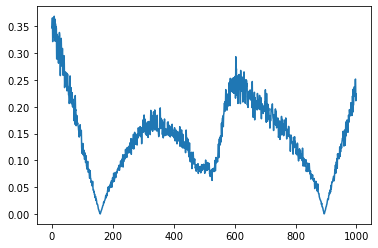

In [74]:
plt.plot(pstd)

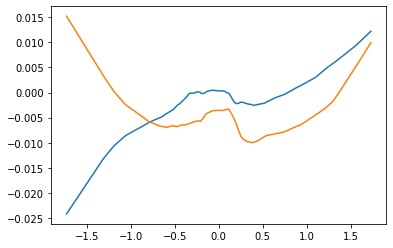

In [55]:
plt.plot(x_train_scaled, model.predict(x_train_scaled))
# plt.plot(x_train_scaled, y_train_scaled, alpha=0.1)


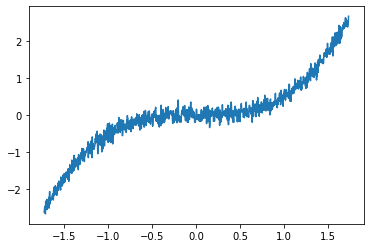

In [32]:
plt.plot(x_train_scaled, y_train_scaled)

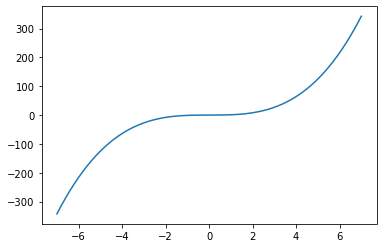

In [49]:
plt.plot(x_test, y_test)

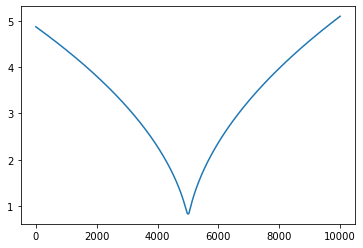

In [31]:
plt.plot(np.sqrt(model.predict(x_train)[:, 1]))

In [18]:
model.predict(x_test)#[:, 0]

array([[-32.30511 ,  88.610756],
       [-32.298687,  88.59336 ],
       [-32.292263,  88.57598 ],
       ...,
       [ 29.45974 ,  96.154335],
       [ 29.465668,  96.17323 ],
       [ 29.471596,  96.19212 ]], dtype=float32)

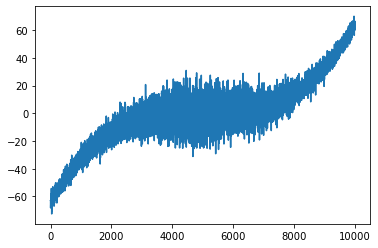

In [14]:
plt.plot(y_train)

In [7]:
# Create some training and testing data
x_train, y_train = my_data(-4, 4, 10000)
x_test, y_test = my_data(-7, 7, 10000, train=False)

# Define our model with an evidential output
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    # tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dense(64, activation="relu"),
    DenseNormalGamma(1),
])
input_scaler = StandardScaler()
output_scaler = StandardScaler()
# input_scaler = MinMaxScaler((0.1, 1.1))
# output_scaler = MinMaxScaler((0.1, 1.1))
x_train_scaled = input_scaler.fit_transform(x_train)
y_train_scaled = output_scaler.fit_transform(y_train)
x_test_scaled = input_scaler.transform(x_test)
y_test_scaled = output_scaler.transform(y_test)
# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return EvidentialRegression(true, pred, coeff=1e-3)

# Compile and fit the model!
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=EvidentialRegressionLoss)
model.fit(x_train, y_train, batch_size=1000, epochs=500, verbose=1)
# model.fit(x_train_scaled, y_train_scaled, batch_size=1000, epochs=500, verbose=0)


# # Predict and plot using the trained model
# # y_pred = model.predict(x_test_scaled)
# y_pred = model.predict(x_test)

# plot_predictions(x_train, y_train, x_test, y_test, y_pred)
# # plot_predictions_scaled(x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, y_pred)


# # y_pred = model.predict(x_test)
# # y_pred = model.predict(x_test_scaled)
# mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
# mu = mu[:, 0]
# x_test = x_test[:, 0]
# y_test = y_test[:, 0]

# aleatoric = np.sqrt((beta / (alpha-1))).squeeze()
# epistemic = np.sqrt((beta / (v *(alpha - 1)))).squeeze()

Epoch 1/500
10/10 [==============================] - 1s 3ms/step - loss: 7.7668
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 6.7706
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 6.0262
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 5.3425
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 4.8039
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 4.5441
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 4.4179
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 4.3579
Epoch 9/500
10/10 [==============================] - 0s 3ms/step - loss: 4.3019
Epoch 10/500
10/10 [==============================] - 0s 3ms/step - loss: 4.2554
Epoch 11/500
10/10 [==============================] - 0s 3ms/step - loss: 4.2140
Epoch 12/500
10/10 [==============================] - 0s 3ms/step - loss: 4.1759
Epoch 13/500
10/10 [=================

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x2b30e62cd160>
Traceback (most recent call last):
  File "/glade/work/cbecker/miniconda3/envs/xai/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



In [173]:
aleatoric = np.sqrt((beta / (alpha-1))).squeeze()
epistemic = np.sqrt((beta / (v *(alpha - 1)))).squeeze()

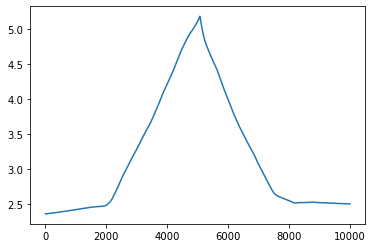

In [174]:
plt.plot(aleatoric)

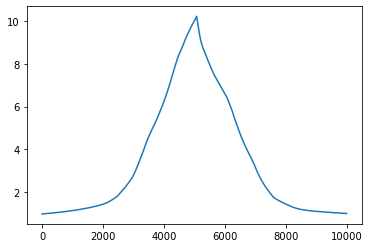

In [175]:
plt.plot(epistemic)

(-3.03078582, 3.03078582)

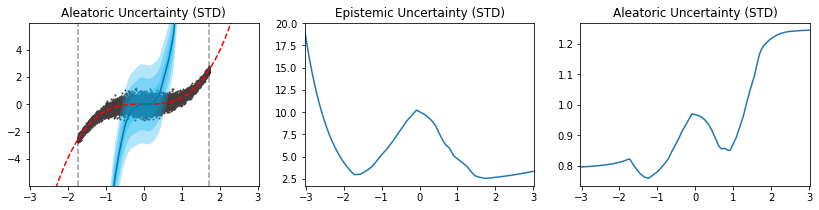

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
axes[1].plot(x_test_scaled, epistemic)
axes[1].set_title('Epistemic Uncertainty (STD)')
axes[2].plot(x_test_scaled, aleatoric)
axes[2].set_title('Aleatoric Uncertainty (STD)')
axes[0].scatter(x_train_scaled, y_train_scaled, s=1., c='#463c3c', zorder=0, label="Train")
axes[0].plot(x_test_scaled, y_test_scaled, 'r--', zorder=2, label="True")
axes[0].plot(x_test_scaled, mu, color='#007cab', zorder=3, label="Pred")
axes[0].plot([-1.73187761, -1.73187761], [-5.98085315, 5.98085315], 'k--', alpha=0.4, zorder=0)
axes[0].plot([+1.73187761, +1.73187761], [-5.98085315, 5.98085315], 'k--', alpha=0.4, zorder=0)

epistemic_std = epistemic
for k in np.arange(1, 4):
    axes[0].fill_between(
        # x_test, (mu - k * epistemic_std), (mu + k * epistemic_std),
        x_test_scaled[:, 0], (mu - k * aleatoric), (mu + k * aleatoric),

        alpha=0.3,
        edgecolor=None,
        facecolor='#00aeef',
        linewidth=0,
        zorder=1,
        label="Unc." if k == 0 else None)
axes[0].set_title('Aleatoric Uncertainty (STD)')
# axes[0].set_ylim(-150, 150)
# axes[0].set_xlim(-7, 7)
# axes[1].set_xlim(-7, 7)
# axes[2].set_xlim(-7, 7)
axes[0].set_ylim(-5.98085315, 5.98085315)
axes[0].set_xlim(-3.03078582, 3.03078582)
axes[1].set_xlim(-3.03078582, 3.03078582)
axes[2].set_xlim(-3.03078582, 3.03078582)
# plt.show()
# plt.savefig('/glade/scratch/cbecker/synthetic_uncertainty_scaled.png', dpi=200, bbox_inches='tight')

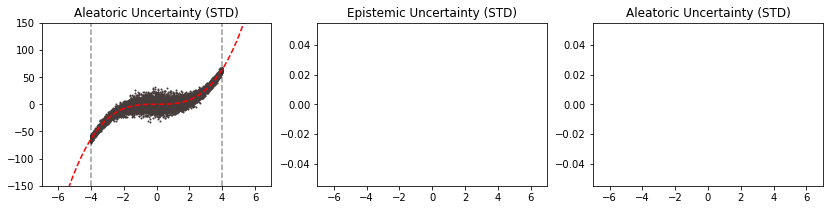

In [314]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
axes[1].plot(x_test, epistemic)
axes[1].set_title('Epistemic Uncertainty (STD)')
axes[2].plot(x_test, aleatoric)
axes[2].set_title('Aleatoric Uncertainty (STD)')
axes[0].scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
axes[0].plot(x_test, y_test, 'r--', zorder=2, label="True")
axes[0].plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
axes[0].plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
axes[0].plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

epistemic_std = epistemic
for k in np.arange(1, 4):
    axes[0].fill_between(
        x_test, (mu - k * epistemic_std), (mu + k * epistemic_std),
        # x_test, (mu - k * aleatoric), (mu + k * aleatoric),

        alpha=0.3,
        edgecolor=None,
        facecolor='#00aeef',
        linewidth=0,
        zorder=1,
        label="Unc." if k == 0 else None)
axes[0].set_title('Aleatoric Uncertainty (STD)')
axes[0].set_ylim(-150, 150)
axes[0].set_xlim(-7, 7)
axes[1].set_xlim(-7, 7)
axes[2].set_xlim(-7, 7)
# plt.show()
plt.savefig('/glade/scratch/cbecker/synthetic_uncertainty_ale.png', dpi=200, bbox_inches='tight')

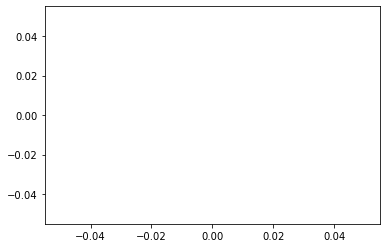

In [316]:
plt.plot(aleatoric)


In [293]:
y_train.std()

25.023919990155417

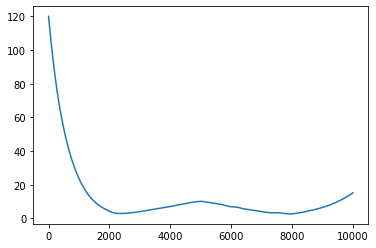

In [294]:
plt.plot(epistemic)

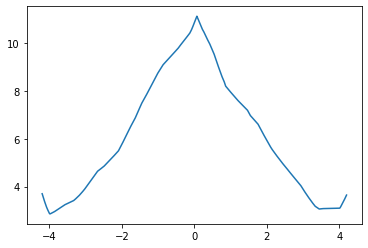

In [65]:
plt.plot(x_test[2000:8000], epistemic[2000:8000])
plt.savefig('/glade/scratch/cbecker/synthetic_uncertainty_epi_zoom.png', dpi=200, bbox_inches='tight')

In [159]:
y_pred = model.predict(x_test_scaled)
mu = output_scaler.inverse_transform(y_pred[:, 0].reshape(-1, 1))
v = input_scaler.inverse_transform(y_pred[:, 1].reshape(-1, 1))
alpha = y_pred[:, 2]
beta = y_pred[:, 3]
ale = np.sqrt(beta / (alpha - 1))
epi = ((beta / (v.squeeze() *(alpha - 1))))

In [172]:
y_pred = output_scaler.inverse_transform(model.predict(x_test_scaled))
mu = y_pred[:, 0]
v = y_pred[:, 1]
alpha = y_pred[:, 2]
beta = y_pred[:, 3]
ale = np.sqrt(beta / (alpha - 1))
epi = ((beta / (v.squeeze() *(alpha - 1))))

/glade/scratch/cbecker/ipykernel_217644/1511679802.py:6: RuntimeWarning: invalid value encountered in sqrt
  ale = np.sqrt(beta / (alpha - 1))


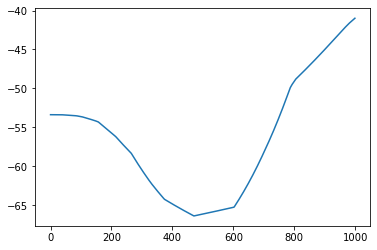

In [178]:
plt.plot(v)

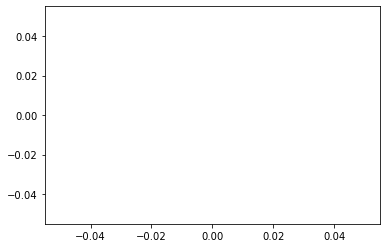

In [175]:
plt.plot(ale)
# plt.plot(epi)

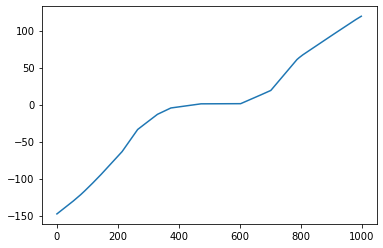

In [125]:
plt.plot(mu)

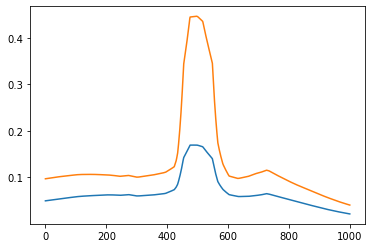

In [87]:
# plt.plot(ale / v)
plt.plot(ale)
plt.plot(epi)

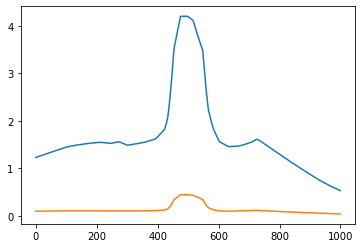

In [88]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1) #np.var(y_train_scaled)

ale = np.sqrt((beta / (alpha - 1)) * np.var(y_train))
epi = np.sqrt((beta / (v * (alpha - 1))))

plt.plot(ale)
plt.plot(epi)

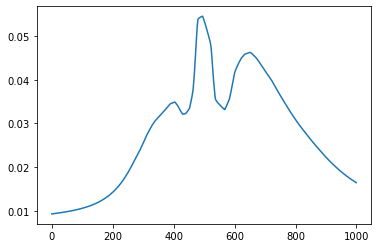

In [230]:
plt.plot(ale-epi)

In [19]:
d = my_data(-4, 4, 1000)[1]
n = np.random.normal(0, 5).astype(np.float32)
plt.plot(d+n)

AttributeError: 'float' object has no attribute 'astype'

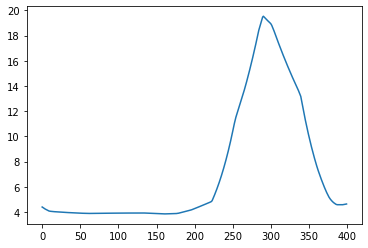

In [285]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
ale = np.sqrt(beta / (alpha - 1))
epi = np.sqrt((beta / (v * (alpha - 1))))

plt.plot(epi[200:600])
# plt.plot(epi)

In [44]:
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)
    # noise2 = np.random.normal(0, 10, 200)
    # t[400:500] = t[400:500] + noise2

    return x, y

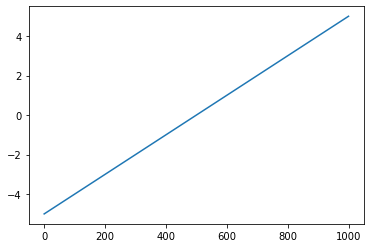

In [45]:
plt.plot(my_data(-5, 5, 1000)[0])

In [232]:
mean_ale = np.mean(ale)
std_ale = np.std(ale)
standard_ale = (ale - mean_ale) / std_ale

mean_epi = np.mean(ale)
std_epi = np.std(ale)
standard_epi = (epi - mean_ale) / std_epi

In [233]:
std_ale

0.012234237

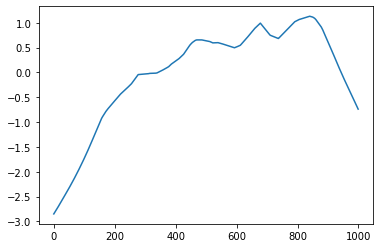

In [236]:
plt.plot(standard_ale)

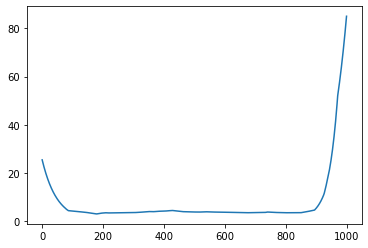

In [177]:
plt.plot(ale / np.sqrt(v))

In [137]:
plt.figure(figsize=(5, 3), dpi=200)
k = 1
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
u = np.sqrt(beta / ((alpha - 1)))[:, 0]
u = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

<Figure size 1000x600 with 0 Axes>

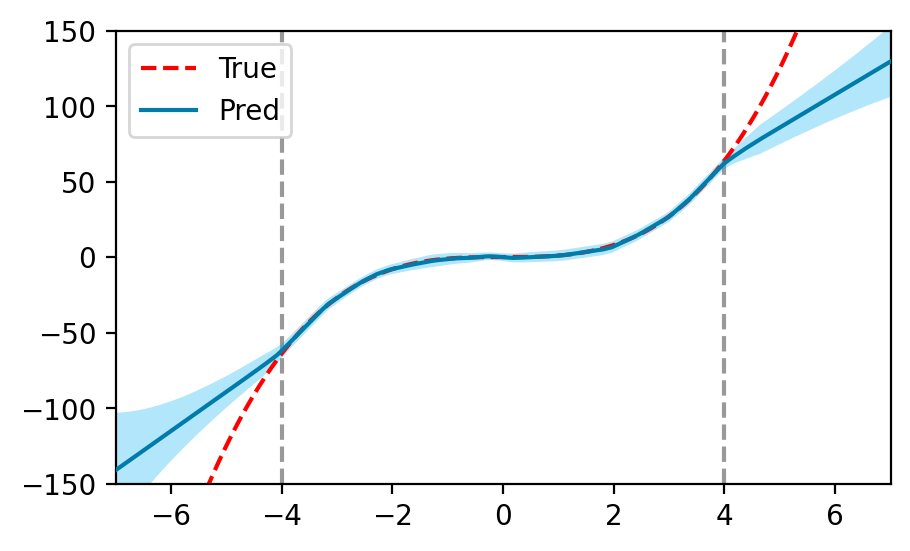

In [124]:
plt.figure(figsize=(5, 3), dpi=200)
k = 1
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
u = np.sqrt(beta / ((alpha - 1)))[:, 0]
u = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

# var = np.minimum(var, 1e3)[:, 0]  # for visualization
plt.plot(x_test[:, 0], y_test, 'r--', zorder=2, label="True")
plt.plot(x_test[:, 0], mu[:, 0], color='#007cab', zorder=3, label="Pred")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.fill_between(
    x_test[:, 0], (mu[:, 0] - k * u), (mu[:, 0] + k * u),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1,
    label="Unc." if k == 0 else None)
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

In [47]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)

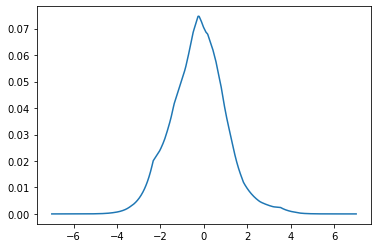

In [60]:
plt.plot(x_test, v)

In [51]:
a = np.sqrt(beta / ((alpha - 1)))[:, 0]
e = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

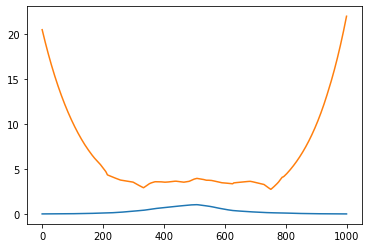

In [55]:
plt.plot(a)
plt.plot(e)


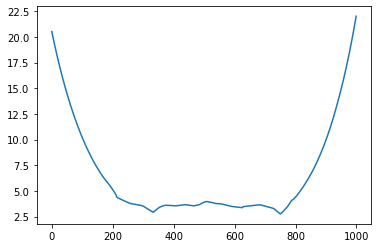

In [54]:
plt.plot(e)

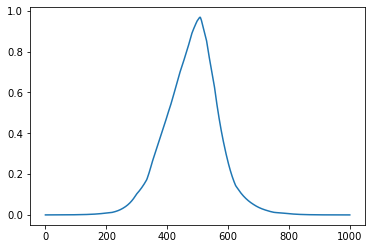

In [56]:
plt.plot(beta)

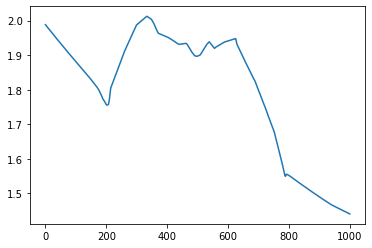

In [57]:
plt.plot(alpha)

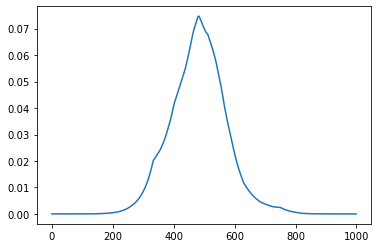

In [58]:
plt.plot(v)